In [2]:
!pip install scikit-image

In [3]:
image_dir = '/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images'
mask_dir = '/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual'

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_niblack, threshold_sauvola
from sklearn.metrics import confusion_matrix

In [16]:

def compute_dice(pred, gt):

    # Ensure binary (0 or 1)
    pred = (pred > 0).astype(np.uint8)
    gt = (gt > 0).astype(np.uint8)

    intersection = np.sum(pred * gt)

    dice = (2.0 * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)

    return dice

In [21]:
def apply_thresholds(img):

    window_size = 43

  
    thresh_niblack = threshold_niblack(img, window_size=window_size, k=-0.2)
    binary_niblack = img < thresh_niblack

   
    thresh_sauvola = threshold_sauvola(img, window_size=window_size)
    binary_sauvola = img < thresh_sauvola

    return binary_niblack.astype(np.uint8), binary_sauvola.astype(np.uint8)

In [7]:
def compute_sensitivity(pred, gt):

    gt = (gt > 0).astype(np.uint8)

    tp = np.sum((pred==1) & (gt==1))
    fn = np.sum((pred==0) & (gt==1))

    sensitivity = tp / (tp + fn + 1e-8)

    return sensitivity

In [17]:
images = sorted(os.listdir(image_dir))
masks = sorted(os.listdir(mask_dir))

import cv2

def preprocess(img):

    green = img[:,:,1]
    green = cv2.equalizeHist(green)

    return green


sens_niblack = []
sens_sauvola = []

dice_niblack = []
dice_sauvola = []

for img_name, mask_name in zip(images, masks):

    img = cv2.imread(os.path.join(image_dir, img_name))
    gt = cv2.imread(os.path.join(mask_dir, mask_name), 0)

    pre = preprocess(img)

    niblack, sauvola = apply_thresholds(pre)

    # Sensitivity
    sens_niblack.append(compute_sensitivity(niblack, gt))
    sens_sauvola.append(compute_sensitivity(sauvola, gt))

    # Dice score
    dice_niblack.append(compute_dice(niblack, gt))
    dice_sauvola.append(compute_dice(sauvola, gt))


print("Average Sensitivity:")
print("Niblack:", np.mean(sens_niblack))
print("Sauvola:", np.mean(sens_sauvola))

print("\nAverage Dice Score:")
print("Niblack:", np.mean(dice_niblack))
print("Sauvola:", np.mean(dice_sauvola))

Average Sensitivity:
Niblack: 0.8814715211317694
Sauvola: 0.5858582665620679

Average Dice Score:
Niblack: 0.2455578928153413
Sauvola: 0.32348471907118725


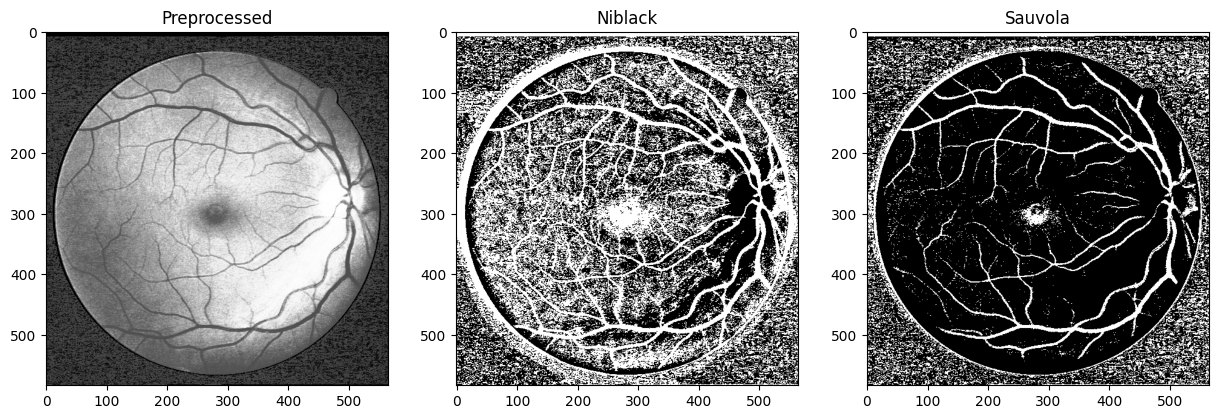

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(pre, cmap='gray')
plt.title("Preprocessed")

plt.subplot(1,3,2)
plt.imshow(niblack, cmap='gray')
plt.title("Niblack")

plt.subplot(1,3,3)
plt.imshow(sauvola, cmap='gray')
plt.title("Sauvola")

plt.show()